Previous:  [Process Monet](pipeline_prepare_monet.ipynb)  ::: Next [pipeline_tuning](pipeline_tuning.ipynb) 
# Example: processing the Movie stimulus
In this notebook, we retrieve spikes inferred from the calcium traces and the synchronized movie stimulus, which may include static frames from the movie.

In [1]:
%pylab inline
import datajoint as dj
from pipeline import preprocess, vis


Populating the interactive namespace from numpy and matplotlib
DataJoint 0.3.7 (July 31, 2016)
Loading local settings from dj_local_conf.json
Connecting dimitri@at-database.ad.bcm.edu:3306


Here we consider the more complex case wherein several different types of stimuli used during each calcium trace scan: `vis.MovieStillCond`, `vis.MovieClipCond`, `vis.MovieSeqCond`. 

All these conditions rely on movie information cached in lookup tables `vis.Movie`, `vis.MovieClip`, and `vis.MovieStill`.

Here are the relevant tables in the `vis` schema:

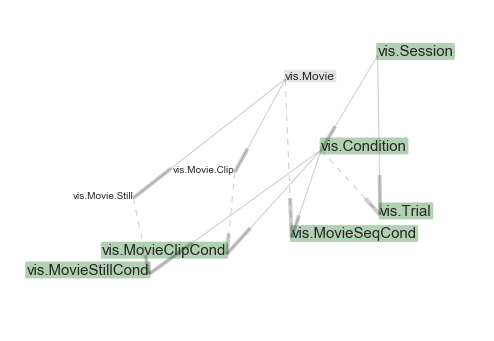

In [2]:
(dj.ERD(vis.Movie)+2+vis.Condition+vis.Trial-1).draw()

The following query denotes all trials combined with synchronization information to their two-photon scans.

In [3]:
trials = preprocess.Sync() * vis.Trial() & 'trial_idx between first_trial and last_trial'

The following step of retrieving the spike traces was explained in detail in [Process Monet](pipeline_prepare_monet.ipynb).

In [4]:
movie_conditions = [vis.MovieSeqCond(), vis.MovieClipCond(), vis.MovieStillCond()]
datasets = (preprocess.Spikes() & 
            (trials & movie_conditions) & 
            dict(extract_method=2, spike_method=5))
datasets

animal_id,session,scan_idx,extract_method,spike_method
8980,1,1,2,5
9036,1,3,2,5


---
Let's fetch the primary key values of these datasets so that we can address them individually:

In [5]:
keys = list(datasets.fetch.keys())     # keys for relevant datasets
key = keys[1]   #  identifies one dataset
dict(key)

{'animal_id': 9036,
 'extract_method': 2,
 'scan_idx': 3,
 'session': 1,
 'spike_method': 5}

---
Now let's fetch all the relevant information for the dataset identified by `key`:

In [6]:
time = (preprocess.Sync() & key).fetch1['frame_times'].squeeze()  # calcium scan frame times
traces = np.vstack((preprocess.Spikes.RateTrace() & key).fetch['rate_trace'])  # fetch traces
nslices = len(time)/traces.shape[1]   # number of slices in recording.
time = time[::nslices]   # keep only one timestamp per frame (ignore time offsets of slices)

----
Now let's iterate through trials of each stimulus type separately

## Movie clip stimulus

Let's iterate through the trials of type `vis.MovieClipCond`. 
Keep in mind that the trials of each type are interleaved.

We are not processing each one now but will only show how to process the last one.

In [7]:
for clip_key in (trials * vis.MovieClipCond() & key).fetch.order_by('trial_idx').keys():
    print('.', end='')

..............................................................................................................

Now let's just look at the last trial addressed by `clip_key` (the last iteration of the loop above) and retrieve the stimulus movie shown during the trial:

In [8]:
clip_info = (vis.Trial()*vis.MovieClipCond()*vis.Movie.Clip() & clip_key).fetch1()

In [9]:
clip_info['clip_number']   # the clip number. Some clips are repeated multiple times.

27

In [10]:
clip_info['cut_after']  # the cut time.  Some clips are cut short.

60.0

The `flip_times` field contains the time stamps of the frames of the movie on the same clock and same units as the `time` retrieved earlier for calcium traces from `preprocess.Sync`:

In [11]:
frame_times = clip_info['flip_times'].flatten()   # the frame times of the visual stimulus

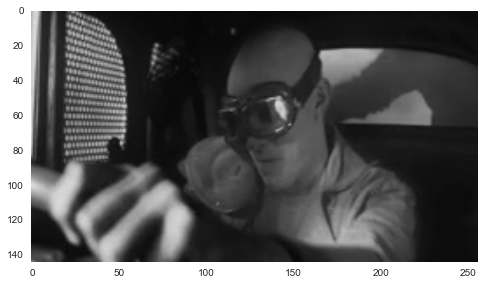

In [12]:
# load the movie
import io, imageio
vid = imageio.get_reader(io.BytesIO(clip_info['clip'].tobytes()), 'ffmpeg')

# show a frame from the movie
plt.imshow(vid.get_data(50))
grid(False)

You may now relate the information in `traces` on `time` with the movie `vid` on `clip_info['flip_times']`. 

## Still frame stimulus
Now let's process responses to stimuli comprising still frames from the movie.  Again let's iterate through all the trials but only look at the last one in depth.

In [13]:
for still_key in (trials * vis.MovieStillCond() & key).fetch.order_by('trial_idx').keys():
    print('.', end='')

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Let's look at the last trial in depth.

In [14]:
still_info = (vis.Trial()*vis.MovieStillCond()*vis.Movie.Still() & still_key).fetch1()

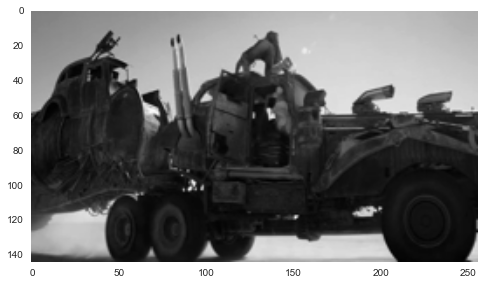

In [15]:
plt.imshow(still_info['still_frame'], cmap='gray')
grid(False)

In [16]:
still_info['flip_times'][0,0]  # frame time on the same clock as `time` for `traces`
still_info['duration']   # duration on the screen

0.5

## Sequence stimulus
The sequence stimulus is still frame stimulus with fixed sequences of frames.  Again, we will iterate through all the trials and examine the last trial in depth. 

In [17]:
for seq_key in (trials * vis.MovieSeqCond() & key).fetch.order_by('trial_idx').keys():
    print('.', end='')

..

In [18]:
seq_info = (vis.Trial()*vis.MovieSeqCond() & seq_key).fetch1()

In [19]:
seq_info['seq_length']

20

In [20]:
seq_info['flip_times'].flatten()   # frame display times on the same clock 

array([  1.46377040e+09,   1.46377040e+09,   1.46377040e+09,
         1.46377040e+09,   1.46377040e+09,   1.46377040e+09,
         1.46377040e+09,   1.46377041e+09,   1.46377041e+09,
         1.46377041e+09,   1.46377041e+09,   1.46377041e+09,
         1.46377041e+09,   1.46377041e+09,   1.46377041e+09,
         1.46377041e+09,   1.46377041e+09,   1.46377041e+09,
         1.46377041e+09,   1.46377041e+09])

In [21]:
np.uint32(seq_info['movie_still_ids'].flatten())   # Movie.Still id numbers

array([ 9675,  2746,  2661,  5329,  4061,  1241,  7504,  5602,  5631,
        9006,  7237,  1886, 11794,     2,  9204,  1972,  4642,  2502,
        5605,   368], dtype=uint32)

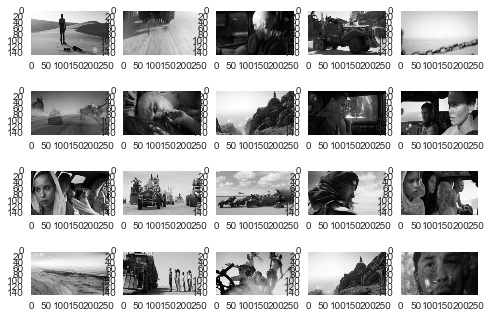

In [22]:
f, ax = plt.subplots(4,int(ceil(seq_info['seq_length']/4)))
for i, a in zip(seq_info['movie_still_ids'].flatten(), ax.flatten()):
    im = (vis.MovieSeqCond()*vis.Movie.Still() & 
          dict(seq_key, still_id=i)).fetch1['still_frame']
    a.imshow(im, cmap='gray')
    a.grid(False)

---
That's it.  That is all it takes to retrieve the data for computing neuronal responses in response to the movie stimulus.

Next [pipeline_tuning](pipeline_tuning.ipynb) 